# 2024 NFL Touchdown Regression

Siddarth Puliyanda

I will be using the 2023 NFL Player stats to see if a player scored more or less touchdowns than expected in the 2023 season.
This can help determine who overperformed or underperformed in the touchdown category for 2023 and if a player is due for a positive or negative touchdown regression for the 2024 season.

The method of analysis will be to find the average amount of touchdowns (TDs) scored for each position in 2023 and compare that to the actual amount of TDs they scored, based on that player's skill position stat (passing attempts, rushing attempts, or receptions). This is essentially expected - observed, or the residual.

The data was pulled from https://www.pro-football-reference.com/years/2023/fantasy.htm

This is a continuation of my yearly Touchdown Regression Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Import and read in data, and view the column names
df = pd.read_excel('2023_Fantasy_Stats.xlsx')[0:151] #Top 150 scoring players
display(df.head())
print(df.columns)

,Rk,Player,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,...,TD.3,14:00:00,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank
0,1,Christian McCaffrey*+,SFO,RB,27,16,16,0,0,0,...,21,NaN,NaN,324,391.3,399.3,357.8,157.0,1,1.0
1,2,CeeDee Lamb*+,DAL,WR,24,17,17,0,0,0,...,14,1.0,NaN,268,403.2,411.2,335.7,131.0,1,2.0
2,3,Josh Allen,BUF,QB,27,17,17,385,579,4306,...,15,NaN,3.0,393,392.6,420.6,410.6,122.0,1,3.0
3,4,Tyreek Hill*+,MIA,WR,29,16,16,0,0,0,...,13,NaN,NaN,257,376.4,380.4,316.9,120.0,2,4.0
4,5,Jalen Hurts*,PHI,QB,25,17,17,352,538,3858,...,15,NaN,NaN,357,356.8,382.8,371.8,89.0,2,5.0


Index([     'Rk',  'Player',      'Tm', 'FantPos',     'Age',       'G',
            'GS',     'Cmp',     'Att',     'Yds',      'TD',     'Int',
         'Att.1',   'Yds.1',     'Y/A',    'TD.1',     'Tgt',     'Rec',
         'Yds.2',     'Y/R',    'TD.2',     'Fmb',      'FL',    'TD.3',
        14:00:00,     '2PP',  'FantPt',     'PPR',    'DKPt',    'FDPt',
           'VBD', 'PosRank',  'OvRank'],
      dtype='object')


We only want to see the top 150 scoring fantasy players from 2023 because players after that are irrelevant fantasy-wise. Also all players who are top 150 scorers probably played more than 5 games, which is a decent amount of games per player given there's only 17 games in a season.

## Clean and Prep Data

In [2]:
#We can see that Attempts, Yards, and TDs have duplicative column names
#Let's rename some of the columns for simplicity
df = df.rename(columns={'Att':'Pass_Atts','Yds':'Pass_Yds','TD':'Pass_TD',
                        'Att.1':'Rush_Att','Yds.1':'Rush_Yds','TD.1':'Rush_TD',
                        'Yds.2':'Yds','TD.2':'Receive_TD','TD.3':'Total_TD'})
df.columns

Index([        'Rk',     'Player',         'Tm',    'FantPos',        'Age',
                'G',         'GS',        'Cmp',  'Pass_Atts',   'Pass_Yds',
          'Pass_TD',        'Int',   'Rush_Att',   'Rush_Yds',        'Y/A',
          'Rush_TD',        'Tgt',        'Rec',        'Yds',        'Y/R',
       'Receive_TD',        'Fmb',         'FL',   'Total_TD',     14:00:00,
              '2PP',     'FantPt',        'PPR',       'DKPt',       'FDPt',
              'VBD',    'PosRank',     'OvRank'],
      dtype='object')

In [3]:
#Confirm that all players played at least 5 games
print(df.sort_values(by = ['G'], inplace = False).head(10))

#Some players have FantPos NaN (like Alex Armah), but they will get filtered out later when we create positional dfs

      Rk           Player   Tm FantPos  Age   G  GS  Cmp  Pass_Atts  Pass_Yds  \
126  127       Joe Flacco  CLE      QB   38   5   5  123        204      1616   
139  140   Deshaun Watson  CLE      QB   28   6   6  105        171      1115   
88    89     Kirk Cousins  MIN      QB   35   8   8  216        311      2331   
90    91     Kyler Murray  ARI      QB   26   8   8  176        268      1799   
146  147   D'Onta Foreman  CHI      RB   27   9   8    0          0         0   
93    94    Jake Browning  CIN      QB   27   9   7  171        243      1936   
124  125       Will Levis  TEN      QB   24   9   9  149        255      1808   
131  132     Tommy DeVito  NYG      QB   25   9   6  114        178      1101   
96    97  Jonathan Taylor  IND      RB   24  10   7    0          0         0   
89    90       Joe Burrow  CIN      QB   27  10  10  244        365      2309   

     ...  Total_TD  14:00:00  2PP  FantPt    PPR   DKPt   FDPt  VBD  PosRank  \
126  ...         0       NaN

In [4]:
# Some player names have characters at the end that we don't need (the * and +). Let's remove them.
df['Player'] = df['Player'].str.replace('*','')
df['Player'] = df['Player'].str.replace('+','')
print(df['Player'].head(10))

0    Christian McCaffrey
1            CeeDee Lamb
2             Josh Allen
3            Tyreek Hill
4            Jalen Hurts
5         Raheem Mostert
6      Amon-Ra St. Brown
7           Dak Prescott
8             Mike Evans
9          Lamar Jackson
Name: Player, dtype: object


/var/folders/m1/ttxn6nhn2s98l9q9llw88ny00000gn/T/ipykernel_54677/2754416600.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Player'] = df['Player'].str.replace('*','')
/var/folders/m1/ttxn6nhn2s98l9q9llw88ny00000gn/T/ipykernel_54677/2754416600.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Player'] = df['Player'].str.replace('+','')


Let's now create new dataframes for each position, only using the necessary statistical columns for each.
The positions will be: Quarterback (QB), Running Back (RB), Wide Receiver (WR), and Tight End (TE).

In [5]:
# Dataframe for Quarterbacks with passing stats
# Only return top 30 because we don't want QBs who barely played to affect the totals
df_qb = df[['Player','Tm','FantPos','Cmp','Pass_Atts','Pass_Yds','Pass_TD','Total_TD','FantPt','PosRank']]
df_qb = df_qb.loc[df_qb['FantPos'] == 'QB'][:30].reset_index(drop=True)
display(df_qb.head())
display(df_qb.tail())

,Player,Tm,FantPos,Cmp,Pass_Atts,Pass_Yds,Pass_TD,Total_TD,FantPt,PosRank
0,Josh Allen,BUF,QB,385,579,4306,29,15,393,1
1,Jalen Hurts,PHI,QB,352,538,3858,23,15,357,2
2,Dak Prescott,DAL,QB,410,590,4516,36,2,343,3
3,Lamar Jackson,BAL,QB,307,457,3678,24,5,331,4
4,Jordan Love,GNB,QB,372,579,4159,32,4,319,5


,Player,Tm,FantPos,Cmp,Pass_Atts,Pass_Yds,Pass_TD,Total_TD,FantPt,PosRank
25,Kyler Murray,ARI,QB,176,268,1799,10,3,146,26
26,Jake Browning,CIN,QB,171,243,1936,12,3,143,27
27,Aidan O'Connell,LVR,QB,213,343,2218,12,1,126,28
28,Zach Wilson,NYJ,QB,221,368,2271,8,0,120,29
29,Kenny Pickett,PIT,QB,201,324,2070,6,1,110,30


One thing to note is that QBs could also have positive or negative regression for their rushing TDs. However there
are not enough rushing QBs in the league to make a fair assessment on regression.
Here's the QBs sorted by number of rushing TDs. Only 6 QBs had over 5 rushing TDs (3 of whom are no longer starters) and a majority had 2 or less.
So we will ignore rushing TD regression for QBs.

In [7]:
display(df_qb[['Player','Tm','FantPos','Total_TD']].sort_values('Total_TD', ascending = False).reset_index(drop = True))

,Player,Tm,FantPos,Total_TD
0,Josh Allen,BUF,QB,15
1,Jalen Hurts,PHI,QB,15
2,Joshua Dobbs,2TM,QB,6
3,Lamar Jackson,BAL,QB,5
4,Desmond Ridder,ATL,QB,5
5,Sam Howell,WAS,QB,5
6,Trevor Lawrence,JAX,QB,4
7,Justin Fields,CHI,QB,4
8,Jordan Love,GNB,QB,4
9,Justin Herbert,LAC,QB,3


In [8]:
#Dataframe for Running Backs with rushing stats
df_rb = df[['Player','Tm','FantPos','Rush_Att','Rush_Yds','Rush_TD','FantPt','PosRank']]
df_rb = df_rb.loc[df_rb['FantPos'] == 'RB'].reset_index(drop=True)
df_rb.head()

,Player,Tm,FantPos,Rush_Att,Rush_Yds,Rush_TD,FantPt,PosRank
0,Christian McCaffrey,SFO,RB,272,1459,14,324,1
1,Raheem Mostert,MIA,RB,209,1012,18,243,2
2,Travis Etienne,JAX,RB,267,1008,11,224,3
3,Kyren Williams,LAR,RB,228,1144,12,223,4
4,Derrick Henry,TEN,RB,280,1167,12,219,5


In [9]:
#Dataframe for Wide Receivers with receiving stats
df_wr = df[['Player','Tm','FantPos','Tgt','Rec','Yds','Receive_TD','FantPt','PosRank']]
df_wr = df_wr.loc[df_wr['FantPos'] == 'WR'].reset_index(drop=True)
df_wr.head()

,Player,Tm,FantPos,Tgt,Rec,Yds,Receive_TD,FantPt,PosRank
0,CeeDee Lamb,DAL,WR,181,135,1749,12,268,1
1,Tyreek Hill,MIA,WR,171,119,1799,13,257,2
2,Amon-Ra St. Brown,DET,WR,164,119,1515,10,212,3
3,Mike Evans,TAM,WR,136,79,1255,13,204,4
4,Puka Nacua,LAR,WR,160,105,1486,6,194,5


In [10]:
#Dataframe for Tight Ends with receiving stats
df_te = df[['Player','Tm','FantPos','Tgt','Rec','Yds','Receive_TD','FantPt','PosRank']]
df_te = df_te.loc[df_te['FantPos'] == 'TE'].reset_index(drop=True)
df_te.head()

,Player,Tm,FantPos,Tgt,Rec,Yds,Receive_TD,FantPt,PosRank
0,Sam LaPorta,DET,TE,120,86,889,10,153,1
1,George Kittle,SFO,TE,90,65,1020,6,138,2
2,Travis Kelce,KAN,TE,121,93,984,5,126,3
3,T.J. Hockenson,MIN,TE,127,95,960,5,124,4
4,David Njoku,CLE,TE,123,81,882,6,120,5


## Analysis

Now that we have all the dataframes for each position, let's create a function that takes a dataframe, finds the average TDs per significant stat (completions for QBs, rush attempts for RBs, or receptions for WRs or TEs), and returns a new dataframe with how much more or less points the player should have scored for the season.

I will create residual plots for given stat (pass attempt, rush attempt, reception) vs. residual (expected - observed). Players below the line overperformed in the touchdown category (and might be due for negative regression) and players above the line underperformed (and might be due for positive regression).

In [12]:
#Create function that can take any skill position's dataframe
#Note: 1 touchdown = 6 fantasy points, but 1 passing touchdown = 4 fantasy points

def avg_x_to_td(df): # x represents either pass attempts, rush attempts, or receptions based on the position
    dfnew = df.copy()
    avg_att = dfnew['Pass/Rush/Reception'].mean() #Find average number of input stat per position
    avg_td = dfnew['TD_Edit'].mean() #Find average number of TDs per position
    avg_att_to_td = avg_att/avg_td #Find average stat to TD ratio per position
    dfnew['Expected_TD'] = dfnew['Pass/Rush/Reception']/avg_att_to_td #New column for expected number of TDs in 2023
    dfnew['TD_diff'] = dfnew['Expected_TD']-dfnew['TD_Edit'] #New column for expected - observed TDs scored in 2023
    if (df['FantPos'] == 'QB').all(): #If player is QB passing TDs are 4 points, other positions TDs are 6 points
        dfnew['FantPt_+/-'] = dfnew['TD_diff']*4        
    else:    
        dfnew['FantPt_+/-'] = dfnew['TD_diff']*6
    dfnew['2023_New'] = dfnew['FantPt_+/-'] + dfnew['FantPt'] #Create column for expected 2023 points
    dfnew = dfnew.sort_values('FantPt_+/-', ascending = False)
    dfnew = dfnew[['PosRank','Player','Tm','FantPos','Pass/Rush/Reception','FantPt','FantPt_+/-','2023_New']].reset_index(drop = True)
    dfnew = dfnew.rename(columns = {'PosRank':'2023 Rank'}) #Observed 2023 rank that we can compare to our expected
    return dfnew

This is a general function we can use for all position, but we must rename the columns for each dataframe so they can be input into the function.

In [13]:
#Rename the columns for each position dataframe
#Create new variables for each edit so that the original dataframes aren't affected
df_qb_edit = df_qb.rename(columns = {'Pass_Atts':'Pass/Rush/Reception', 'Pass_TD': 'TD_Edit'})
df_rb_edit = df_rb.rename(columns = {'Rush_Att':'Pass/Rush/Reception', 'Rush_TD': 'TD_Edit'})
df_wr_edit = df_wr.rename(columns = {'Rec':'Pass/Rush/Reception', 'Receive_TD': 'TD_Edit'})
df_te_edit = df_te.rename(columns = {'Rec':'Pass/Rush/Reception', 'Receive_TD': 'TD_Edit'})

Now let's run the function against each position's dataframe.
We can use the data in the 'FantPt_+/-' column to make predictions about the player's 2023 performance. If their
value is high and positive they are due for a positive TD regression, and the opposite if the value is negative.

In [14]:
#Quarterbacks
qb_new = avg_x_to_td(df_qb_edit)
qb_new

,2023 Rank,Player,Tm,FantPos,Pass/Rush/Reception,FantPt,FantPt_+/-,2023_New
0,23,Bryce Young,CAR,QB,527,156,48.407531,204.407531
1,30,Kenny Pickett,PIT,QB,324,110,32.812220,142.812220
2,29,Zach Wilson,NYJ,QB,368,120,32.527460,152.527460
3,21,Gardner Minshew II,IND,QB,490,196,25.919716,221.919716
4,14,Sam Howell,WAS,QB,612,257,23.311972,280.311972
5,20,Joshua Dobbs,2TM,QB,417,201,21.119432,222.119432
6,22,Desmond Ridder,ATL,QB,388,176,20.034387,196.034387
7,12,Trevor Lawrence,JAX,QB,564,263,14.895346,277.895346
8,28,Aidan O'Connell,LVR,QB,343,126,12.143801,138.143801
9,19,Geno Smith,SEA,QB,499,226,7.497833,233.497833


/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


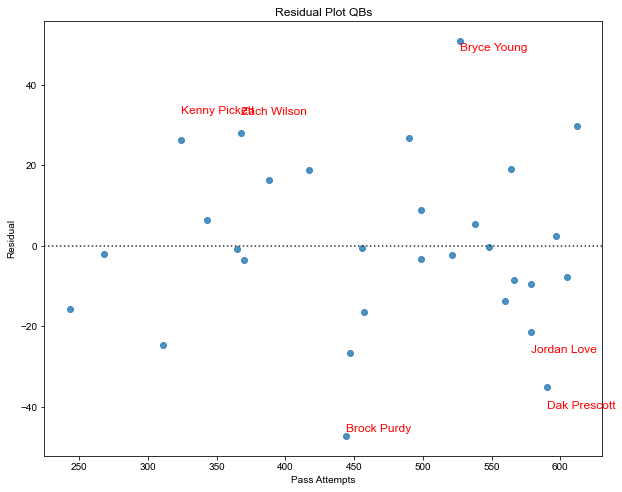

In [15]:
#Plot top and bottom 3 Quarterback names on residual plot
#Create scatterplot of names
fig, ax = plt.subplots(figsize=(10, 8))
notable_players = ['Brock Purdy', 'Dak Prescott', 'Jordan Love', 'Bryce Young', 'Kenny Pickett','Zach Wilson']
for player_name in notable_players:    
    player = qb_new.loc[qb_new['Player'] == player_name]
    # if our df we get back is not empty, run the code below
    if not player.empty:
        # grab Pass/Rush/Reception value and Fantasy Point difference value
        prr = player['Pass/Rush/Reception']
        points = player['FantPt_+/-']
        ax.annotate(player_name, xy=(prr, points), color='red', fontsize=12)
#Create plot
sns.set_style('darkgrid')
sns.residplot(qb_new['Pass/Rush/Reception'], qb_new['FantPt_+/-'])
plt.title('Residual Plot QBs')
plt.xlabel('Pass Attempts')
plt.ylabel('Residual')
plt.show()

Observations:
- Bryce Young is at the top of the list. He is probably due for a positive passing TD regression since in 2023 he threw less TDs per pass attempts than the league average. This makes sense because he is a rookie and probably adjusting to the NFL level. The team added a few pass catchers so this should help him see positive TD regression.
- 2 of the 3 at the bottom of the list are Brock Purdy and Jordan Love. Both of these QBs are young new QBs in the league, and both have a great coaching staff and receiving corp. Despite this, I would expect some TD regression to occur as their rate of TDs last year was incredibly high.
- One interesting note is the CJ Stroud, who had one of the greatest rookie QB seasons of all time, ranked middle of the pack for TD regression. Given the Texans just added an elite WR and Stroud has another year under his belt, I would not be surprised to see him increase his TD output next season.

In [16]:
#Running Backs
rb_new = (avg_x_to_td(df_rb_edit))
rb_new

,2023 Rank,Player,Tm,FantPos,Pass/Rush/Reception,FantPt,FantPt_+/-,2023_New
0,38,Alexander Mattison,MIN,RB,180,103,34.360807,137.360807
1,11,James Cook,BUF,RB,237,189,33.241729,222.241729
2,32,Javonte Williams,DEN,RB,217,132,23.423862,155.423862
3,40,AJ Dillon,GNB,RB,178,96,21.979020,117.979020
4,29,Devin Singletary,HOU,RB,216,137,17.232968,154.232968
5,33,Ezekiel Elliott,NWE,RB,184,124,17.124380,141.124380
6,12,Bijan Robinson,ATL,RB,214,188,16.851182,204.851182
7,8,Rachaad White,TAM,RB,272,204,15.922997,219.922997
8,26,Chuba Hubbard,CAR,RB,238,144,15.432622,159.432622
9,36,Aaron Jones,GNB,RB,142,105,15.106859,120.106859


/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


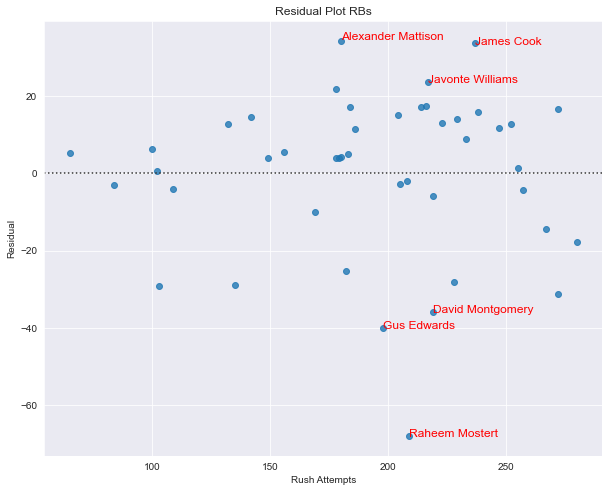

In [17]:
#Plot top and bottom 3 Running Back names on residual plot
#Create scatter plot of names
fig, ax = plt.subplots(figsize=(10, 8))
notable_players = ['Raheem Mostert', 'Gus Edwards', 'David Montgomery', 'Alexander Mattison', 'James Cook', 'Javonte Williams']
for player_name in notable_players:    
    player = rb_new.loc[rb_new['Player'] == player_name]
    # if our df we get back is not empty, run the code below
    if not player.empty:
        # grab Pass/Rush/Reception value and Fantasy Point difference value
        prr = player['Pass/Rush/Reception']
        points = player['FantPt_+/-']
        ax.annotate(player_name, xy=(prr, points), color='red', fontsize=12)
#Create plot
sns.set_style('darkgrid')
sns.residplot(rb_new['Pass/Rush/Reception'], rb_new['FantPt_+/-'], ax=ax)
plt.title('Residual Plot RBs')
plt.xlabel('Rush Attempts')
plt.ylabel('Residual')
plt.show()

Observations:
- 2nd from the top is James Cook, who scored 4 rushing TDs in 2023. Given he is the top RB on a run heavy team, I would expect positive regression to come from his TDs next season.
- 3rd from the top is Javonte Williams, who scored 5 rushing TDs in 2023. Given he is now 2 years removed from his ACL injury and Sean Payton ability to feature the RB position, I would expect more TDs to come his way next year.
- At the very bottom of the list, we have Raheem Mostert who had a whopping 18 rushing TDs. Since this is by far the most TDs he's seen in his career, he's now age 31, and De'Von Achane rising, I would definitely expect strong negative TD regression.

In [18]:
#Wide Receivers
wr_new = (avg_x_to_td(df_wr_edit))
wr_new

,2023 Rank,Player,Tm,FantPos,Pass/Rush/Reception,FantPt,FantPt_+/-,2023_New
0,25,Michael Pittman Jr.,IND,WR,109,141,29.885238,170.885238
1,33,Chris Godwin,TAM,WR,83,126,29.031878,155.031878
2,36,Garrett Wilson,NYJ,WR,95,118,28.964198,146.964198
3,31,Adam Thielen,CAR,WR,103,128,26.919078,154.919078
4,42,Drake London,ATL,WR,69,105,22.110839,127.110839
5,48,Josh Downs,IND,WR,68,89,21.616479,110.616479
6,55,Tyler Boyd,CIN,WR,67,78,21.122119,99.122119
7,5,Puka Nacua,LAR,WR,105,194,15.907798,209.907798
8,29,Terry McLaurin,WAS,WR,79,130,15.054438,145.054438
9,50,Jerry Jeudy,DEN,WR,54,88,14.695439,102.695439


/Users/siddthekidd/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


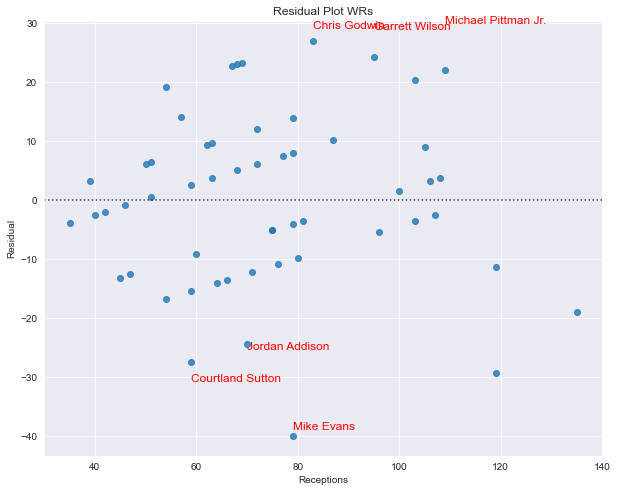

In [19]:
#Plot top and bottom 3 Wide Receiver names on residual plot
#Create scatterplot of names
fig, ax = plt.subplots(figsize=(10, 8))
notable_players = ['Michael Pittman Jr.','Chris Godwin','Garrett Wilson','Mike Evans',"Courtland Sutton",'Jordan Addison']
for player_name in notable_players:    
    player = wr_new.loc[wr_new['Player'] == player_name]
    # if our df we get back is not empty, run the code below
    if not player.empty:
        # grab Pass/Rush/Reception value and Fantasy Point difference value
        prr = player['Pass/Rush/Reception']
        points = player['FantPt_+/-']
        ax.annotate(player_name, xy=(prr, points), color='red', fontsize=12)
#Create plot
sns.set_style('darkgrid')
sns.residplot(wr_new['Pass/Rush/Reception'], wr_new['FantPt_+/-'])
plt.title('Residual Plot WRs')
plt.xlabel('Receptions')
plt.ylabel('Residual')
plt.show()

Observations:
- At the top of the list is Mike Evans and 2nd to the bottom is Chris Godwin. Both of them play for the same team, so it would not be surprising to see both of them return to the mean next year. For Evans, I would be more worried about him reaching his TD count again since he will be in age 31 season and the team lost OC Dave Canales.
- Garrett Wilson is 3rd from the bottom, and one of my favorite targets for next year. He's been riddled with some of the worst QB play for his whole career, but now we should have a healthy Aaron Rodgers to boost his numbers up. The talent is unquestionable.
- Courtland Sutton is 2nd from the top, and I would expect his TD numbers to regress down since he now has a rookie QB.

In [21]:
#Tight Ends
te_new = (avg_x_to_td(df_te_edit))
te_new

,2023 Rank,Player,Tm,FantPos,Pass/Rush/Reception,FantPt,FantPt_+/-,2023_New
0,6,Evan Engram,JAX,TE,114,116,25.695257,141.695257
1,10,Trey McBride,ARI,TE,81,101,17.309788,118.309788
2,4,T.J. Hockenson,MIN,TE,95,124,11.412714,135.412714
3,3,Travis Kelce,KAN,TE,93,126,10.540868,136.540868
4,13,Kyle Pitts,ATL,TE,53,84,5.103935,89.103935
5,7,Taysom Hill,NOR,TE,33,111,2.385469,113.385469
6,9,Jake Ferguson,DAL,TE,71,106,0.950555,106.950555
7,5,David Njoku,CLE,TE,81,120,-0.690212,119.309788
8,8,Cole Kmet,CHI,TE,73,108,-4.177598,103.822402
9,11,Dalton Schultz,HOU,TE,59,92,-4.280525,87.719475


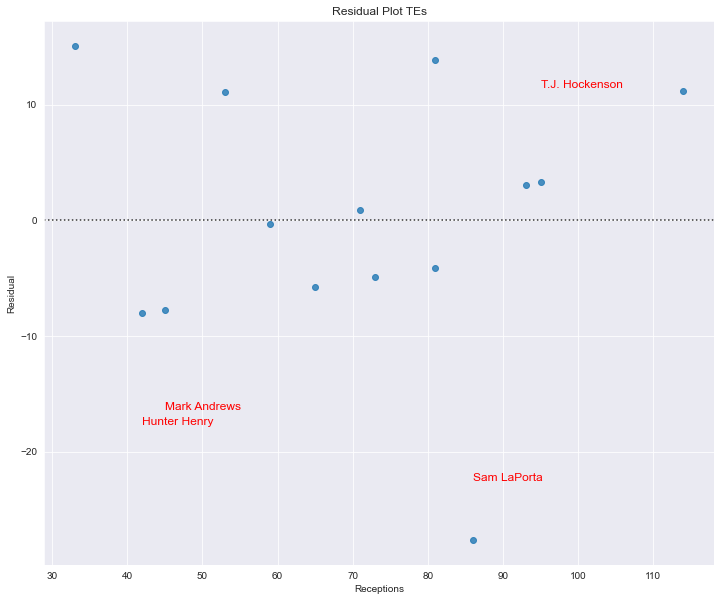

In [23]:
#Plot top and bottom 3 Tight End names on residual plot
#Create scatterplot of names
fig, ax = plt.subplots(figsize=(12, 10))
notable_players = ['Mark Andrews','Hunter Henry','Sam LaPorta','T.J. Hockenson','Trey McBride','Evan Engram']
for player_name in notable_players:    
    player = te_new.loc[te_new['Player'] == player_name]
    # if our df we get back is not empty, run the code below
    if not player.empty:
        # grab Pass/Rush/Reception value and Fantasy Point difference value
        prr = player['Pass/Rush/Reception']
        points = player['FantPt_+/-']
        ax.annotate(player_name, xy=(prr, points), color='red', fontsize=12)
#Create plot
sns.set_style('darkgrid')
sns.residplot(te_new['Pass/Rush/Reception'], te_new['FantPt_+/-'])
plt.title('Residual Plot TEs')
plt.xlabel('Receptions')
plt.ylabel('Residual')
plt.show()

Observations:

- There are only 14 TEs on this list, which makes sense since there are so few good and consistent TEs in the NFL.
- At the top of the list is Evan Engram, who only had 4 TD for his 114 receptions. Not known to be a TD scorer, if he gets the same volume as last year I would expect the TDs to be higher.
- At the bottom of the list is Sam LaPorta, who is likely due for a negative TD regression as he scored significantly more TDs than expected in 2023. Every TE who has scored 10+ TDs on under 900 yards has regressed in the category the following year, so I would be skeptical to expect them to score more TDs in the next year.

## Conclusions

- The TD regression won't tell the full story of how well we think a player will do in 2024 as there are many outside factors that can contribute to success, such as overall talent, trading for/away players, and who each team drafts in the 2024 NFL Draft.

- The model takes into account the number of pass attempts, rushing attempts, and receptions, which is important to include because it can determine a player's usage as well. By looking at the residual plots, we can see how much a player was used in the offense and how their fantasy output might have changed (for better or worse) after applying the touchdown regression. The further a player is away from the middle line of the graph, the more regression they might be due for. Ideally, we would target players that have a high usage.

- If you want to use this data to help with a Fantasy Football Draft in 2024, you can also sort the values in the 2023_New column in descending order to find the expected rankings of each player in 2023. I would likely target players who not only finished high on the rankings in 2023, but are also due for some positive TD regression.

- We will not be able to tell if our conclusions were accurate until the end of the 2024 season, but it will be useful to compare our conclusions to the actual results.